# Redes neuronales hibridas  para clasificación multiple


In [1]:
# Install the relevant packages.
#%pip install --upgrade pip
#%pip install torch torchvision torchaudio
#%pip install cudaq -> ya viene instalado en el braket de AWS

In [14]:
# Check installed clasico
import sys
import numpy as np
import matplotlib
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {matplotlib.__version__}")

import torch, torchvision, torchaudio
print("torch:", torch.__version__)
print("vision:", torchvision.__version__)
print("audio:", torchaudio.__version__)

Python version: 3.12.3 (main, Aug 14 2025, 17:47:21) [GCC 13.3.0]
NumPy version: 1.26.4
Matplotlib version: 3.10.7
torch: 2.5.1+cu121
vision: 0.20.1+cu121
audio: 2.5.1+cu121


In [15]:

import cudaq
print(f"CUDAQ version: {cudaq.__version__}")
print(f"Running on target: {cudaq.get_target().name}")

CUDAQ version: CUDA-Q Version amd64-cu12-latest (https://github.com/NVIDIA/cuda-quantum 27466446afbb91a7e9e4b2c93b7ca351e978d674)
Running on target: qpp-cpu


In [17]:
import sys
import cudaq

print(f"Running on target {cudaq.get_target().name}")
qubit_count = 2


@cudaq.kernel
def kernel():
    qubits = cudaq.qvector(qubit_count)
    h(qubits[0])
    for i in range(1, qubit_count):
        x.ctrl(qubits[0], qubits[i])
    mz(qubits)


result = cudaq.sample(kernel)
print(result)  # Example: { 11:500 00:500 }

Running on target qpp-cpu


CompilerError: 3244825406.py:10: [91merror: [0m[1mCUDA-Q does not allow assignment to variable qubits captured from parent scope.
	 (offending source -> qubits = cudaq.qvector(qubit_count))[0m

In [11]:
# importar las librerías necesarias
import cudaq
from cudaq import spin

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Para asegurar que los resultados sean reproducibles
torch.manual_seed(42)

cudaq.set_random_seed(44)

In [6]:
# Configurar el dispositivo
# Set CUDAQ and PyTorch to run on either CPU or GPU.

device = torch.device('cpu')
cudaq.set_target("qpp-cpu")

#cudaq.set_target("nvidia")
#device = torch.device("cuda:0")

## Descripción del Conjunto de Datos MNIST

- *¿Qué es?:* MNIST (Modified National Institute of Standards and Technology database) es una gran base de datos de dígitos escritos a mano, del 0 al 9.
- *Contenido:* Contiene 70,000 imágenes en escala de grises.
- *Conjunto de entrenamiento:* 60,000 imágenes.
- *Conjunto de prueba:* 10,000 imágenes.
- *Formato de imagen:* Cada imagen tiene un tamaño de 28x28 píxeles.
- *Uso común:* Es considerado el "Hola, Mundo" de la visión por computadora y el aprendizaje profundo. Se utiliza para entrenar y probar algoritmos de clasificación de imágenes.


Paso 2: Cargar, Transformar y Previsualizar los Datos
torchvision nos facilita la descarga y preparación de datasets.

Transformaciones: Convertimos las imágenes a tensores de PyTorch y las normalizamos. La normalización (ajustar los valores de los píxeles para que tengan una media de 0.5 y una desviación estándar de 0.5) ayuda a que el modelo entrene más rápido y de forma más estable.
Descarga: Descargamos los conjuntos de entrenamiento y prueba. FashionMNIST ya viene separado en train y test.

In [7]:
# 1. Definir las transformaciones para las imágenes
# - transforms.ToTensor() convierte la imagen (PIL) a un Tensor de PyTorch.
# - transforms.Normalize() ajusta los valores del tensor para que tengan una media y desviación estándar específicas.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)) # Media y Desviación Estándar para un solo canal (escala de grises)
])

# 2. Descargar los datasets de entrenamiento y prueba
train_full_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=False, 
    download=True, 
    transform=transform
)

print(f"Tamaño total del dataset de entrenamiento: {len(train_full_dataset)}")
print(f"Tamaño del dataset de prueba: {len(test_dataset)}")


Tamaño total del dataset de entrenamiento: 60000
Tamaño del dataset de prueba: 10000


In [8]:
# --- MODIFICACIÓN: Usar solo 1000 muestras para una prueba rápida ---
from torch.utils.data import Subset

# 1. Creamos un subconjunto con las primeras 1000 imágenes del dataset de entrenamiento completo
n_samples_prueba = 1000
train_subset_for_testing = Subset(train_full_dataset, range(n_samples_prueba))

# 2. Ahora, basamos la división 80/20 en este subconjunto de 1000 muestras
train_size = int(0.8 * len(train_subset_for_testing)) # 80% de 1000 = 800
val_size = len(train_subset_for_testing) - train_size # 20% de 1000 = 200

# Dividimos el dataset de entrenamiento
train_dataset, val_dataset = random_split(train_subset_for_testing, [train_size, val_size])

print(f"Tamaño del subconjunto de entrenamiento: {len(train_dataset)}")
print(f"Tamaño del subconjunto de validación: {len(val_dataset)}")

# Crear los DataLoaders
# Los DataLoaders nos permiten iterar sobre los datos en lotes (batches)
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Tamaño del subconjunto de entrenamiento: 800
Tamaño del subconjunto de validación: 200


--- Previsualización de Datos (MNIST) ---


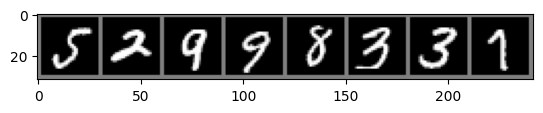

Etiquetas:  5     2     9     9     8     3     3     7    


In [9]:
# Clases de MNIST (dígitos del 0 al 9)
classes = tuple(str(i) for i in range(10))

# Función para mostrar imágenes (sin cambios)
def imshow(img):
    img = img / 2 + 0.5  # Des-normalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Obtener un lote de imágenes de entrenamiento
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Mostrar las primeras 8 imágenes y sus etiquetas
print("--- Previsualización de Datos (MNIST) ---")
imshow(torchvision.utils.make_grid(images[:8]))
print('Etiquetas: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))


In [14]:
# --- Guardar los pesos del modelo entrenado ---

def save_model(model, name):
    # Define el nombre del archivo donde se guardarán los pesos.
    RUTA_MODELO = f"{name}.pth"
    # Usamos model.state_dict() para obtener solo los parámetros aprendibles.
    torch.save(model.state_dict(), RUTA_MODELO)
    print(f"¡Modelo guardado exitosamente en {RUTA_MODELO}!")

save_model(model, "cnn_mnist_weights")

¡Modelo guardado exitosamente en cnn_mnist_weights.pth!


## Implementación del Modelo Híbrido Cuántico-Clásico

Ahora, construiremos y entrenaremos el modelo híbrido. Este modelo combinará capas convolucionales clásicas para la extracción de características con un circuito cuántico parametrizado para el procesamiento de la información.

In [26]:
from torch.autograd import Function
from cudaq import spin
n_qubits = 4
n_quantum_features = 3 * n_qubits # 3 observables (X, Y, Z) por qubit

# Define el kernel cuántico parametrizado
kernel, features = cudaq.make_kernel(list)
qubits = kernel.qalloc(n_qubits)

# Codificación de características con rotaciones RY
for i in range(n_qubits):
    kernel.ry(features[i], qubits[i])

# Entrelazamiento con compuertas CNOT
for i in range(n_qubits - 1):
    kernel.cx(qubits[i], qubits[i + 1])

# Define los observables a medir (X, Y, Z para cada qubit)
hamiltonian_list = []
for i in range(n_qubits):
    hamiltonian_list.append(spin.x(i))
    hamiltonian_list.append(spin.y(i))
    hamiltonian_list.append(spin.z(i))
hamiltonian = sum(hamiltonian_list)

class QuantumFunction(Function):
    """Función de autograd para ejecutar el circuito y calcular gradientes."""
    
    @staticmethod
    def forward(ctx, x: torch.Tensor):
        """Pase hacia adelante: ejecuta el circuito cuántico."""
        ctx.save_for_backward(x)
        
        # Esta versión de CUDA-Q no soporta batching directo de tensores 2D.
        # Debemos iterar sobre cada elemento del lote.
        exp_vals_list = []
        for i in range(x.shape[0]):
            # Pasamos cada fila (1D tensor) por separado.
            result_future = cudaq.observe_async(kernel, hamiltonian, x[i])
            exp_vals_list.append(result_future.get().expectation())
        
        # Convierte la lista de resultados a un tensor de PyTorch
        output = torch.tensor(exp_vals_list, device=x.device, dtype=x.dtype).reshape(-1, 1)
        return output

    @staticmethod
    def backward(ctx, grad_output: torch.Tensor):
        """Pase hacia atrás: calcula gradientes con parameter-shift."""
        x, = ctx.saved_tensors
        batch_size, n_params = x.shape
        
        # Inicializa el tensor para los gradientes
        gradients = torch.zeros_like(x)
        
        # Itera sobre cada característica de entrada (parámetro del circuito)
        for i in range(n_params):
            # Crea copias del tensor de entrada para el shift
            x_plus = x.clone()
            x_minus = x.clone()
            
            # Aplica el shift a la característica i
            x_plus[:, i] += np.pi / 2.0
            x_minus[:, i] -= np.pi / 2.0
            
            # Ejecuta los circuitos con shift
            exp_vals_plus_list = []
            exp_vals_minus_list = []
            for j in range(batch_size):
                future_plus = cudaq.observe_async(kernel, hamiltonian, x_plus[j])
                future_minus = cudaq.observe_async(kernel, hamiltonian, x_minus[j])
                exp_vals_plus_list.append(future_plus.get().expectation())
                exp_vals_minus_list.append(future_minus.get().expectation())
            
            exp_vals_plus = torch.tensor(exp_vals_plus_list, device=x.device, dtype=x.dtype)
            exp_vals_minus = torch.tensor(exp_vals_minus_list, device=x.device, dtype=x.dtype)
            
            # Calcula el gradiente para la característica i
            gradient_component = 0.5 * (exp_vals_plus - exp_vals_minus)
            
            # Acumula el gradiente ponderado por el gradiente de la salida
            gradients[:, i] = (gradient_component * grad_output).sum(dim=1)
            
        return gradients

class QuantumLayer(nn.Module):
    """Capa que encapsula la función cuántica."""
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return QuantumFunction.apply(x)

class HybridCNN(nn.Module):
    """Red Neuronal Híbrida: CNN Clásica + Capa Cuántica"""
    def __init__(self, n_qubits: int = 4):
        super(HybridCNN, self).__init__()
        self.n_qubits = n_qubits
        self.n_quantum_features = 3 * n_qubits
        
        # Parte clásica: Convoluciones
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.flatten = nn.Flatten()
        self.pre_quantum_fc = nn.Linear(64 * 5 * 5, self.n_qubits)
        self.quantum_layer = QuantumLayer()
        self.post_quantum_fc = nn.Linear(1, 10) # La entrada ahora es 1 (el valor de expectación del H total)
    
    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.pre_quantum_fc(x)
        
        # Normalizar la entrada a la capa cuántica a [0, pi] como ángulos de rotación
        x = torch.sigmoid(x) * np.pi
        
        x = self.quantum_layer(x)
        logits = self.post_quantum_fc(x)
        return logits

# Crear instancia del modelo híbrido
device = "cuda" if torch.cuda.is_available() else "cpu"
hybrid_model = HybridCNN(n_qubits=n_qubits).to(device)
print("\n--- Arquitectura del Modelo Híbrido ---")
print(hybrid_model)


--- Arquitectura del Modelo Híbrido ---
HybridCNN(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (pre_quantum_fc): Linear(in_features=1600, out_features=4, bias=True)
  (quantum_layer): QuantumLayer()
  (post_quantum_fc): Linear(in_features=1, out_features=10, bias=True)
)


In [13]:

# --- Creación y Validación del Modelo ---

# Crear instancia del modelo híbrido
hybrid_model = HybridCNN(n_qubits=n_qubits).to(device)
print("\n--- Arquitectura del Modelo Híbrido ---")
print(hybrid_model)

# --- Test de Validación Cuántico-Clásico (Forward y Backward) ---
print("\n--- Realizando Test de Validación Cuántico-Clásico ---")

# 1. Crear un lote de datos de prueba
test_input = torch.randn(4, 1, 28, 28).to(device) # Usamos un batch de 4
print(f"Input shape: {test_input.shape}")

# 2. Realizar el pase hacia adelante (Forward Pass)
output = hybrid_model(test_input)
print(f"Output shape: {output.shape}")
print("✅ ¡El pase hacia adelante (Forward) funciona correctamente!")

# 3. Simular el pase hacia atrás (Backward Pass)
# Creamos un objetivo (target) y una función de pérdida (loss) ficticios
target = torch.randint(0, 10, (4,)).to(device) # 4 etiquetas aleatorias para el batch
loss_fn_test = nn.CrossEntropyLoss()
loss = loss_fn_test(output, target)
loss.backward() # Esto calcula los gradientes

# 4. Verificar que los gradientes han fluido a través de la capa cuántica
grad_pre_quantum = hybrid_model.pre_quantum_fc.weight.grad
if grad_pre_quantum is not None and grad_pre_quantum.abs().sum() > 0:
    print("✅ ¡El pase hacia atrás (Backward) funciona! Los gradientes fluyen a través de la capa cuántica.")
else:
    print("❌ ¡Error en el pase hacia atrás! No se calcularon los gradientes para la capa pre-cuántica.")


--- Arquitectura del Modelo Híbrido ---
HybridCNN(
  (conv_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (pre_quantum_fc): Linear(in_features=1600, out_features=4, bias=True)
  (quantum_layer): QuantumLayer()
  (post_quantum_fc): Linear(in_features=1, out_features=10, bias=True)
)

--- Realizando Test de Validación Cuántico-Clásico ---
Input shape: torch.Size([4, 1, 28, 28])
Output shape: torch.Size([4, 10])
✅ ¡El pase hacia adelante (Forward) funciona correctamente!
✅ ¡El pase hacia atrás (Backward) funciona! Los gradientes fluyen a través de la capa cuántica.


### Entrenamiento del Modelo Híbrido

Ahora, entrenaremos el modelo híbrido usando el mismo bucle de entrenamiento que para el modelo clásico. Notarás que el entrenamiento puede ser más lento debido a la simulación de los circuitos cuánticos.

In [14]:
# Definir la función de pérdida y el optimizador para el modelo híbrido
loss_fn_hybrid = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(hybrid_model.parameters(), lr=1e-3)

# Bucle principal de entrenamiento para el modelo híbrido
epochs = 10
print("\n--- Iniciando Entrenamiento del Modelo Híbrido con MNIST ---")
for t in range(epochs):
    print(f"Época {t+1}\n-------------------------------")
    print("Entrenando (Híbrido)...")
    train_loop(train_loader, hybrid_model, loss_fn_hybrid, optimizer_hybrid)
    print("Validando (Híbrido)...")
    validation_loop(val_loader, hybrid_model, loss_fn_hybrid)
print("¡Entrenamiento híbrido finalizado!")

# Evaluar el modelo híbrido en el conjunto de prueba
print("\n--- Evaluando Modelo Híbrido con el conjunto de Prueba (Test) ---")
validation_loop(test_loader, hybrid_model, loss_fn_hybrid)

# Guardar los pesos del modelo híbrido entrenado
save_model(hybrid_model, "hybrid_cnn_mnist_weights")


--- Iniciando Entrenamiento del Modelo Híbrido con MNIST ---
Época 1
-------------------------------
Entrenando (Híbrido)...


NameError: name 'train_loop' is not defined